## Initialization

In [1]:
import os
import re
import json
import nltk
import pandas as pd
import datetime as dt
import numpy as np
import operator
import math
from nltk.stem.wordnet import WordNetLemmatizer
import multiprocessing
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
%matplotlib inline

### set experiment dates

In [2]:
date_start = dt.datetime.strptime("2005-01-01", "%Y-%m-%d")
date_end = dt.datetime.strptime("2018-06-30", "%Y-%m-%d") 

### set run prefix

In [3]:
run_prefix = "run_09_xx"

### set root directories

In [4]:
dir_root = os.path.join('..')
dir_data_raw = os.path.join(dir_root, "data_raw")
dir_data_processing = os.path.join(dir_root, "data_processing")
dir_data_runs = os.path.join(dir_root, "data_runs")
dir_prices = os.path.join(dir_data_processing, "prices")

### set flags

In [5]:
flag_debug = False
flag_terms_filter_debug = False
flag_use_strist_word_set = False
flag_rerun_cleaning = True
flag_test_report_names = False
flag_run_topics_analysis = True

### create a run directory

In [6]:
dir_run = os.path.join(dir_data_runs, run_prefix)

In [7]:
if not os.path.exists(dir_run):
    os.makedirs(dir_run)

## Clean reports

Make sure that all nltk data sets are available

In [8]:
nltk.download("wordnet")
nltk.download("words")
nltk.download("stopwords")
nltk.download("omw")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alan.spark/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/alan.spark/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alan.spark/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw to /Users/alan.spark/nltk_data...
[nltk_data]   Package omw is already up-to-date!


True

In [9]:
english_words_set = None
english_words_set_soft = set(nltk.corpus.words.words())
english_words_set_strict = set([x.strip() for x in open(os.path.join(dir_data_raw, "english", "strict_words.txt"), "r")])
lemmatizer = WordNetLemmatizer().lemmatize

if flag_use_strist_word_set:
    english_words_set = english_words_set_strict
else:
    english_words_set = english_words_set_soft

### Create stop words set

In [10]:
stop_words_set = set(nltk.corpus.stopwords.words("english"))

Extend stop words with custom stop words

In [11]:
with open(os.path.join(dir_data_raw, "english", "extra_stopwords.txt"), "r") as f_r:
    for text_line in f_r:
        term = text_line.strip()
        stop_words_set.add(term)

Craeate a white list of stop words

In [12]:
white_list_set = set()
with open(os.path.join(dir_data_raw, "english", "white_stopwords.txt"), "r") as f_r:
    for text_line in f_r:
        term = text_line.strip()
        white_list_set.add(term)

Define a funtion checker for stop words. A word is stop word if any of the folowing true:
- it's length shorter then 4 char
- it contains digits
- it appears in nltk stop words set

In [13]:
def is_stop_term(term):
    if term in white_list_set:
        return False
    if len(term) < 4:
        return True
    return term in stop_words_set

Define a funtion lemmatizer

In [14]:
regexp_to_relax = re.compile(r"[az]+\-[a-z]+")

def get_word_lemma(possible_word):
    if is_stop_term(possible_word):
        return None
    if (possible_word not in english_words_set) and (not regexp_to_relax.match(term)):
        return None
    
    possible_lemma = lemmatizer(possible_word)
    
    if not is_stop_term(possible_lemma):
        return possible_lemma
    
    return None

In [15]:
regexp_to_remove = re.compile(r"[\dâºâãï½ã\_]")

Define a clean report function

In [16]:
def clean_report(file_report_path, set_eliminated_terms):
    document = dict()
    with open(os.path.join(file_report_path), "r",  encoding="ISO-8859-1") as f_r:
        for text_line in f_r:
            cleaned_text = re.sub(regexp_to_remove, " ", text_line)
            words = re.split("\W+", cleaned_text)
            for word in words:
                word_lower = word.lower()
                term = get_word_lemma(word_lower)
                if term is not None:
                    if term in document:
                        document[term] += 1
                    else:
                        document[term] = 1    
                elif flag_terms_filter_debug:
                    set_eliminated_terms.add(word_lower)
    return document

Iterate over all reports, clean and convert them to term frequency map, store as csv file

In [17]:
check_report_name_reg_exp = "(?P<ticker>[A-Z1-9]+)[_-](?P<type>[A-Z]+)(?P<number>[1-9]*)(?P<subnumber>-[1-9]+)?[-_](?P<year>[0-9]{4})[_-](?P<p_year>[0-9]{4})"


In [18]:
dir_reports_raw = os.path.join(dir_data_raw, "reports_txt")
dir_reports =  os.path.join(dir_data_processing, "reports")
dir_eliminated_terms = os.path.join(dir_data_processing, "terms_elemenated")

The following cell takes quite a while, be carefull and do not rerun it without a reason, results are stored at file system

In [19]:
def ticker_reports_processing(dir_findex, ticker):
    set_eliminated_terms = set()
    dir_ticker = os.path.join(dir_findex, ticker)
    print("working on %s at %s" % (dir_ticker, dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")))
    if os.path.isdir(dir_ticker):
        ticker_documents_amount = 0
        ticker_code = "%s_%s" % (ticker, findex)
        for report_file_name in os.listdir(dir_ticker):
            match = re.search(check_report_name_reg_exp, report_file_name)
            if not match:
                print("filename %s doesn't fit pattern" % report_file_name)
            else:
                dict_report = clean_report(os.path.join(dir_ticker, report_file_name), set_eliminated_terms)
                if len(dict_report):
                    ticker_documents_amount += 1
                    new_file_name = "%s-%s.csv" % (match.group("p_year"), ticker_documents_amount)
                    new_path = os.path.join(dir_reports, ticker_code)
                    if not os.path.exists(new_path):
                        os.makedirs(new_path)
                    with open(os.path.join(new_path, new_file_name), "w") as f_w:
                        for term, tf in dict_report.items():
                            f_w.write("%s,%s\n" % (term, tf))
                elif flag_debug:
                    print("report %s is empty after cleaning" % report_file_name)
        if len(set_eliminated_terms):
            with open(os.path.join(dir_eliminated_terms, "%s.txt" % ticker_code), "w") as f_w:
                for eliminated in sorted(set_eliminated_terms):
                    f_w.write("%s\n" % (eliminated))

In [20]:
def test_reports_names(dir_findex, ticker):
    dir_ticker = os.path.join(dir_findex, ticker)
    if os.path.isdir(dir_ticker):
        ticker_documents_amount = 0
        ticker_code = "%s_%s" % (ticker, findex)
        for report_file_name in os.listdir(dir_ticker):
            match = re.search(check_report_name_reg_exp, report_file_name)
            if not match:
                print("working on %s, filename %s doesn't fit pattern" % (ticker_code, report_file_name))

In [21]:
if flag_rerun_cleaning or flag_test_report_names:
    for findex in os.listdir(dir_reports_raw):
        dir_findex = os.path.join(dir_reports_raw, findex)
        if os.path.isdir(dir_findex):
            with multiprocessing.Pool(processes=4) as pool:
                if flag_test_report_names: 
                    pool.starmap(test_reports_names, [(dir_findex, ticker) for ticker in os.listdir(dir_findex)])
                else:
                    pool.starmap(ticker_reports_processing, [(dir_findex, ticker) for ticker in os.listdir(dir_findex)])
  

working on ../data_raw/reports_txt/XETRA/.DS_Store at 2019-02-22 11:13:00
working on ../data_raw/reports_txt/XETRA/TUI1 at 2019-02-22 11:13:00
working on ../data_raw/reports_txt/CAC/AC at 2019-02-22 11:13:05
working on ../data_raw/reports_txt/CAC/CA at 2019-02-22 11:13:05
working on ../data_raw/reports_txt/CAC/EDF at 2019-02-22 11:13:05
working on ../data_raw/reports_txt/CAC/ACA at 2019-02-22 11:13:05
working on ../data_raw/reports_txt/CAC/CS at 2019-02-22 11:13:13
working on ../data_raw/reports_txt/CAC/ORA at 2019-02-22 11:13:19
working on ../data_raw/reports_txt/CAC/.DS_Store at 2019-02-22 11:13:21
working on ../data_raw/reports_txt/CAC/AIR at 2019-02-22 11:13:21
working on ../data_raw/reports_txt/CAC/ML at 2019-02-22 11:13:23
working on ../data_raw/reports_txt/CAC/AI at 2019-02-22 11:13:24
working on ../data_raw/reports_txt/CAC/MC at 2019-02-22 11:13:24
working on ../data_raw/reports_txt/CAC/CAP at 2019-02-22 11:13:34
working on ../data_raw/reports_txt/CAC/BN at 2019-02-22 11:13:43


working on ../data_raw/reports_txt/DJIA/MSFT at 2019-02-22 11:18:10
working on ../data_raw/reports_txt/DJIA/CAT at 2019-02-22 11:18:10
working on ../data_raw/reports_txt/DJIA/PFE at 2019-02-22 11:18:11
working on ../data_raw/reports_txt/DJIA/IBM at 2019-02-22 11:18:12
working on ../data_raw/reports_txt/DJIA/MCD at 2019-02-22 11:18:12
filename .DS_Store doesn't fit pattern
working on ../data_raw/reports_txt/DJIA/T at 2019-02-22 11:18:17
working on ../data_raw/reports_txt/DJIA/BTI at 2019-02-22 11:18:19
working on ../data_raw/reports_txt/DJIA/PG at 2019-02-22 11:18:27
working on ../data_raw/reports_txt/DJIA/XOM at 2019-02-22 11:18:30
working on ../data_raw/reports_txt/DJIA/HSBC at 2019-02-22 11:18:32
working on ../data_raw/reports_txt/DJIA/GE at 2019-02-22 11:18:33
working on ../data_raw/reports_txt/DJIA/CSCO at 2019-02-22 11:18:35
working on ../data_raw/reports_txt/DJIA/TVE at 2019-02-22 11:18:38
working on ../data_raw/reports_txt/DJIA/UNH at 2019-02-22 11:18:40
working on ../data_raw/r

In [22]:
eliminated_words = set()
for file in os.listdir(dir_eliminated_terms):
    if not file.endswith('.DS_Store'):
        with open(os.path.join(dir_eliminated_terms, file), "r") as f_r:
            for text in f_r:
                eliminated_words.add(text.strip())
if flag_terms_filter_debug:
    print("list of eliminated terms, size(%s)" % len(eliminated_words))
    for eliminated in sorted(eliminated_words):
        print(" %s " % eliminated)

## Get tickers for analisys

We want to find all tickers of companies which have reports for the experiment's timeframe.

In [23]:
file_tickers_years = os.path.join(dir_data_processing, "tickers", "tickers_years.datajson")

In [24]:
tickers = dict()
for ticker in os.listdir(dir_reports):
    dir_ticker = os.path.join(dir_reports, ticker)
    if os.path.isdir(dir_ticker):
        ticker_years_set = set()
        for report in os.listdir(dir_ticker):
            ticker_years_set.add(int(report[:4]))
        tickers[ticker] = sorted(ticker_years_set)

save years of companies

In [25]:
with open(file_tickers_years, "w") as f_w:
    for ticker in tickers:
        f_w.write("%s\n" % json.dumps({"ticker": ticker, "available_years": tickers[ticker]}))

Find tickers with reports for every year in the experiment timeframe

In [26]:
year_series = list(range(date_start.year, date_end.year)) 

In [27]:
if flag_debug:
    print(year_series)

In [28]:
dir_data_tickers = os.path.join(dir_data_processing, "tickers")
file_tickers_for_analysis = os.path.join(dir_data_tickers, "ticker_for_analysis.csv")

In [29]:
tickers_fits_for_analysis = set()
for ticker, available_years in tickers.items():
    flag_complete_series = True
    available_years_set = set(available_years)
    for year in year_series:
        if year not in available_years_set:
            flag_complete_series = False
            break
    if flag_complete_series and os.path.exists(os.path.join(dir_prices, "%s.csv" % ticker)):
        tickers_fits_for_analysis.add(ticker)

In [30]:
"there are %s tickers available for the experiment" % len(tickers_fits_for_analysis)

'there are 78 tickers available for the experiment'

save companies with complete years series

In [31]:
with open(file_tickers_for_analysis, "w") as f_w:
    for ticker in tickers_fits_for_analysis:
        f_w.write("%s\n" % ticker)

## Return table

### Set paths

In [32]:
dir_ticker_prices = os.path.join(dir_data_processing, "prices")

Iterate over tickers available for analisys and build a return table

In [33]:
tickers_prices_table = {}
for ticker in tickers_fits_for_analysis:
    file_ticker_prices = os.path.join(dir_ticker_prices, ticker + ".csv")
    if os.path.isfile(file_ticker_prices):
        price_df = pd.read_csv(file_ticker_prices)
        price_df["Date"] = pd.to_datetime(price_df["Date"])
        price_df.sort_values(by=["Date"], inplace=True)
        price_df.set_index("Date", inplace=True)
        ticker_data = {}
        
        prev_day = None
        date_stat_price = dt.datetime.strptime("%s-01-01" % (date_start.year + 1), "%Y-%m-%d")
        
        for index, day in price_df[date_stat_price : date_end].iterrows():
            if prev_day is None:
                ticker_data[index] = 1
            else:
                ticker_data[index] = day["Adj Close"] / prev_day["Adj Close"]
            prev_day = day
        tickers_prices_table[ticker] = ticker_data

Convert to pandas data frame

In [34]:
df_return = pd.DataFrame.from_dict(tickers_prices_table)

In [35]:
file_return_table = os.path.join(dir_run, run_prefix + "-returns.csv")
df_return.to_csv(file_return_table)

## Get corpus statistics 

In [36]:
number_of_documents = 0
term_in_documents_amount = {}

In [37]:
for ticker in tickers_fits_for_analysis:
    dir_ticker = os.path.join(dir_reports, ticker)
    if os.path.isdir(dir_ticker):
        for report in os.listdir(dir_ticker):
            if '.csv' in report:
                number_of_documents += 1  
                with open(os.path.join(dir_ticker, report), 'r') as f_r:
                    for text_line in f_r:
                        (term, amount) = text_line.strip().split(',')
                        if term not in term_in_documents_amount:
                            term_in_documents_amount[term] = {
                                'term': term,
                                'total_usage': 0,
                                'in_documents_amount': 0}
                        term_in_documents_amount[term]['total_usage'] += int(amount)
                        term_in_documents_amount[term]['in_documents_amount'] += 1


In [38]:
number_of_documents

5152

In [39]:
"there are %s terms available for the experiment" % len(term_in_documents_amount) 

'there are 28094 terms available for the experiment'

## Filtered term set

### set terms limits

In [40]:
min_number_of_doc = 10
remove_n_top_terms = 500
max_partition_of_doc = 0.6
max_number_of_doc = number_of_documents * max_partition_of_doc

### get top N most common terms

In [41]:
set_top_n_terms_filter = set()
sorted_terms = sorted(list(term_in_documents_amount.values()),
                      key=operator.itemgetter('total_usage'),
                      reverse=True)
for i in range(remove_n_top_terms):
    set_top_n_terms_filter.add(sorted_terms[i]['term'])
    if flag_debug:
        print("Excluded term: %s" % sorted_terms[i]['term'])


### build terms set

In [42]:
set_eliminated_by_max_df = set()
set_eliminated_by_min_df = set()
set_eliminated_by_max_tf = set()

terms_set = set()
for term_o in sorted_terms:
    term = term_o['term']
    in_documents_amount = term_o['in_documents_amount']
    total_usage = term_o['total_usage']
    if term not in set_top_n_terms_filter:
        if in_documents_amount < max_number_of_doc:
            if in_documents_amount > min_number_of_doc:
                terms_set.add(term)
            elif flag_terms_filter_debug:
                set_eliminated_by_min_df.add(term)        
        elif flag_terms_filter_debug:
            set_eliminated_by_max_df.add(term)
    elif flag_terms_filter_debug:
            set_eliminated_by_max_tf.add(term)

In [43]:
"there are %s filtered terms available for the experiment" % len(terms_set) 

'there are 14135 filtered terms available for the experiment'

### Eliminated by exiding maximum terms frequency

In [44]:
print("Eliminated: %s" % len(set_eliminated_by_max_tf))
for eliminated in sorted(set_eliminated_by_max_tf):
    print(" %s " % eliminated)

Eliminated: 0


### Eliminated by exiding maximum document frequency

In [45]:
print("Eliminated: %s" % len(set_eliminated_by_max_df))
for eliminated in sorted(set_eliminated_by_max_df):
    print(" %s " % eliminated)

Eliminated: 0


### Eliminated by no reaching minimum document frequency

In [46]:
print("Eliminated: %s" % len(set_eliminated_by_min_df))
for eliminated in sorted(set_eliminated_by_min_df):
    print( "%s " % eliminated)

Eliminated: 0


# Corpus construction

## Create term -> id  and id -> term dictionary

In [47]:
dict_term2id = {}
dict_id2term = {}

id_counter = 0
terms_list = sorted(terms_set)
for term in terms_list:
    dict_term2id[term] = id_counter
    dict_id2term[id_counter] = term
    id_counter += 1

## Define a function report vectorization

In [48]:
def vectorize_report_dtm(file_report):
    vector_report = list()
    with open(file_report, 'r') as f_r:
        for text_line in f_r:
            term, tf = text_line.strip().split(',')
            if term in dict_term2id:
                vector_report.append("%s:%s" % (dict_term2id[term], tf))
    return vector_report

In [49]:
def vectorize_report_test(file_report, dict_term2id_local, dict_id2term_local):
    local_term_id = 0
    vector_report = list()
    with open(file_report, 'r') as f_r:
        for text_line in f_r:
            term, tf = text_line.strip().split(',')
            if term in dict_term2id:
                if term not in dict_term2id_local:
                    dict_term2id_local[term] = local_term_id
                    dict_id2term_local[local_term_id] = term
                    local_term_id += 1
                vector_report.append((dict_term2id_local[term], int(tf)))
    return vector_report

# Find optimal topic number

In [50]:
def get_quality_corpus(year):
    dict_term2id_year = {}
    dict_id2term_year = {}

    corpus_of_year = []
    for ticker in sorted(tickers_fits_for_analysis):
        dir_ticker_reports = os.path.join(dir_reports, ticker)
        for report in os.listdir(dir_ticker_reports):
            if int(report[:4]) == year:
                file_report = os.path.join(dir_ticker_reports, report)
                corpus_of_year.append(vectorize_report_test(file_report, dict_term2id_year, dict_id2term_year))
    
    return dict_id2term_year, corpus_of_year      

In [51]:
def get_quality_measurements(year, dictionary, corpus, limit, start=2, step=3):
    topics_nums = []
    coherence_values = []
    perplexity_values = []
    for num_topics in range(start, limit + 1, step):
        topics_nums.append(num_topics)
        lda_model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics, 
            random_state=100,
            passes=10,
            iterations=50,
            alpha="auto",
            per_word_topics=True)
        perplexity = lda_model.log_perplexity(corpus)
        perplexity_values.append(perplexity)
        coherence_model_lda = CoherenceModel(
            model=lda_model,
            corpus=corpus,
            dictionary=dictionary,
            coherence='u_mass')
        coherence = coherence_model_lda.get_coherence()
        coherence_values.append(coherence)
        
        #print("Topics: %s, coh: %s, perplex: %s" % (num_topics, coherence, perplexity))
    return {
        "year": year,
        "topics_num": topics_nums,
        "coherence_values": coherence_values,
        "perplexity_values": perplexity_values
    }

In [52]:
topic_min = 5
topic_max = 50
topic_step = 1
measures = []
if flag_run_topics_analysis:
    #for year in year_series:
    year = year_series[0]
    dict_id2term_year, corpus_of_year = get_quality_corpus(year)
    print("Work on %s year, dictionary size: %s" % (year, len(dict_id2term_year)))
    measures.append(
        get_quality_measurements(
            year, 
            dict_id2term_year, 
            corpus_of_year, 
            topic_max, 
            topic_min, 
            topic_step))

Work on 2005 year, dictionary size: 1182


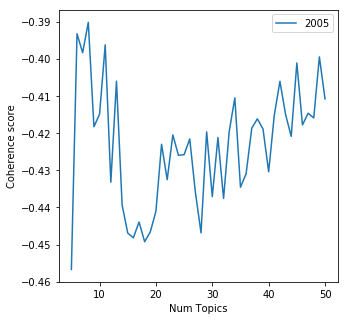

In [53]:
if len(measures):
    plt.figure(figsize=(5,5))
    # Plot all years
    #for year_measures in measures:
        #plt.plot(year_measures["topics_num"], year_measures["coherence_values"], label=year_measures["year"])
        #for i, v in enumerate(year_measures["coherence_values"]):
        #    print("topic: %s :%s" % (year_measures["topics_num"][i], v))
    # Plot a single year
    year_measures = measures[0]
    plt.plot(year_measures["topics_num"], year_measures["coherence_values"], label=year_measures["year"])    
    
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(bbox_to_anchor=(1.002, 1.002))
    plt.show()

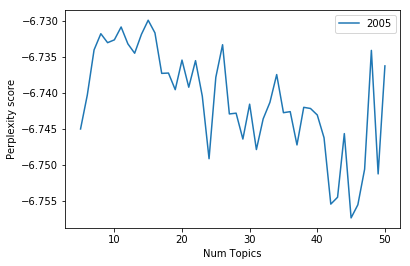

In [54]:
if len(measures):
    for year_measures in measures:
        plt.plot(year_measures["topics_num"], year_measures["perplexity_values"], label=year_measures["year"])
    plt.xlabel("Num Topics")
    plt.ylabel("Perplexity score")
    plt.legend(bbox_to_anchor=(1.002, 1.002))
    plt.show()

In [55]:
for i in range(0, 45, 1):
    print("topics_num:%s  c:%s p:%s" % (measures[0]["topics_num"][i], measures[0]["coherence_values"][i],measures[0]["perplexity_values"][i]))
    
    
    
    
    

topics_num:5  c:-0.45670189079591694 p:-6.745019360767923
topics_num:6  c:-0.3932777454433791 p:-6.740303434481287
topics_num:7  c:-0.39837750204776745 p:-6.734038502717695
topics_num:8  c:-0.3902080728384782 p:-6.731790009505501
topics_num:9  c:-0.41830702930337726 p:-6.733037036557394
topics_num:10  c:-0.4149176539489 p:-6.732645305638474
topics_num:11  c:-0.3962535675580824 p:-6.730856736232738
topics_num:12  c:-0.43322340381802543 p:-6.733202399663377
topics_num:13  c:-0.40603758240173043 p:-6.7345008668345665
topics_num:14  c:-0.4393297326359023 p:-6.731884110536722
topics_num:15  c:-0.4469253049375928 p:-6.729921684010518
topics_num:16  c:-0.4481911496915315 p:-6.73167597744301
topics_num:17  c:-0.4439378684975253 p:-6.737298517224693
topics_num:18  c:-0.44923339211513763 p:-6.73725422840057
topics_num:19  c:-0.4465997829607616 p:-6.739561663798002
topics_num:20  c:-0.4410459168097782 p:-6.735454164204053
topics_num:21  c:-0.4230205975864134 p:-6.739220552832154
topics_num:22  c:

# Build run data

### Read all reports (terms quantity map) for every ticker for every year in analysis

In [56]:
amount_documents_in_series_dict = dict()
documents_name_list = list()
documents_vector_list = list()
for year in year_series:
    amount_documents_in_series = 0
    #for every company read reports of a year
    for ticker in sorted(tickers_fits_for_analysis):
        dir_ticker_reports = os.path.join(dir_reports, ticker)
        for report in os.listdir(dir_ticker_reports):
            if int(report[:4]) == year:
                #read a report
                amount_documents_in_series += 1
                documents_vector_list.append(vectorize_report_dtm(os.path.join(dir_ticker_reports, report)))
                documents_name_list.append(ticker + '-' + report)

    #keep track of documents in series
    amount_documents_in_series_dict[int(year)] = amount_documents_in_series

### write results into files

In [57]:
#save prefix-seq.dat
with open(os.path.join(dir_run, run_prefix + '-seq.dat'), 'w') as f_w:
    f_w.write("%s\n" % len(year_series))
    for year in sorted(amount_documents_in_series_dict.keys()):
        f_w.write("%s\n" % amount_documents_in_series_dict[year])

In [58]:
#save prefix-mult.dat, every document in SVM
with open(os.path.join(dir_run, run_prefix + '-mult.dat'), 'w') as f_w:
    for document in documents_vector_list:
        f_w.write("%s %s\n" % (len(document), ' '.join(document)))

In [59]:
#save prefix-documents.dat, every document the same order with mult.dat
with open(os.path.join(dir_run, run_prefix + '-documents.dat'), 'w') as f_w:
    for document in documents_name_list:
        f_w.write("%s\n" % document)

In [60]:
#save prefix-documents.dat, every document the same order with mult.dat
with open(os.path.join(dir_run, run_prefix + '-terms.dat'), 'w') as f_w:
    for term in terms_list:
        f_w.write("%s\n" % term)

### create result directories

In [61]:
dir_results = os.path.join(dir_run, 'results')

if not os.path.exists(dir_results):
    os.makedirs(dir_results)

In [62]:
dir_results = os.path.join(dir_run, 'interpretation')

if not os.path.exists(dir_results):
    os.makedirs(dir_results)

# Go and run experiment

go go go go go